In [1]:
!pip install rdkit

In [2]:
!pip install padelpy

In [3]:
!pip install lazypredict-nightly

In [4]:
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
import padelpy
from padelpy import padeldescriptor, from_smiles

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style='ticks')
import matplotlib.pyplot as plt

In [6]:
import time
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [7]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, StackingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor

In [8]:
import lazypredict
from lazypredict import LazyRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Preprocessing and feature engineering of the collected data

In [9]:
!wget https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/bioactivity_data/bioactivity_data_raw.csv

--2024-11-20 23:12:00--  https://raw.githubusercontent.com/cpariona/biomedical-thesis/refs/heads/main/data/bioactivity_data/bioactivity_data_raw.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21032 (21K) [text/plain]
Saving to: ‘bioactivity_data_raw.csv’

bioactivity_data_ra 100%[===================>]  20.54K  --.-KB/s    in 0s      

2024-11-20 23:12:00 (89.3 MB/s) - ‘bioactivity_data_raw.csv’ saved [21032/21032]



In [23]:
df = pd.read_csv("bioactivity_data_raw.csv")
df.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')

In [24]:
# Handling missing data && cleaning
df = df.dropna(subset=['standard_value', 'canonical_smiles'])
df = df.drop_duplicates(['canonical_smiles']).reset_index(drop=True)

In [25]:
# Removing insignificant element and keeping the largest compound in each SMILES expression
selected_features=["molecule_chembl_id", "canonical_smiles", "standard_value"]
df = df[selected_features]

smileless= df.drop(columns=['canonical_smiles'])

smiles=[]
for i in df['canonical_smiles'].tolist():
  strg= str(i).split(".")
  strg = max(strg,key= len)
  smiles.append(strg)

smiles=pd.DataFrame(data=smiles, columns=["canonical_smiles"])
df = pd.concat([smileless, smiles], axis=1)

### Discretization

Classify bioactivity to active, inactive and intermediate according to the standard value.

The bioactivity data is in the IC50 unit. Compounds having values of less than 1000 nM will be considered to be active while those greater than 10,000 nM will be considered to be inactive. As for those values in between 1,000 and 10,000 nM will be referred to as intermediate.

In [26]:
# if <= 1000 then active
# if >= 10000 then inactive
# otherwise it is intermediate
bioactivity_class=[]
for i in df['standard_value']:
  if float(i) <= 1000:
    bioactivity_class.append("active")
  elif float(i) >= 10000:
    bioactivity_class.append("inactive")
  else:
    bioactivity_class.append("intermediate")
act_series=pd.Series(bioactivity_class, name="class")
df = pd.concat([df, act_series], axis=1)
df.head()

,molecule_chembl_id,standard_value,canonical_smiles,class
0,CHEMBL8260,8200.00,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,intermediate
1,CHEMBL129451,21400.00,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@H]1c1ccc(O)c(O)...,inactive
2,CHEMBL511367,10300.00,Oc1cc(O)c2cc(O)c(-c3ccc(O)c(O)c3)[o+]c2c1,inactive
3,CHEMBL590878,6500.00,Oc1cc(O)c2cc(O)c(-c3cc(O)c(O)c(O)c3)[o+]c2c1,intermediate
4,CHEMBL59,7100.00,NCCc1ccc(O)c(O)c1,intermediate


In [27]:
df["class"].value_counts()

,count
class,
inactive,10
intermediate,9


In [28]:
df['standard_value'].describe()

,standard_value
count,19.00
mean,14236.84
std,10732.41
min,3600.00
25%,7400.00
50%,10300.00
75%,17350.00
max,46200.00


### Compute Lipinski Discriptors

In [29]:
def lipinski(smiles, verbose=False):
  moldata=[]
  for element in smiles:
    # get all molecules from the smiles
    mol=Chem.MolFromSmiles(element)
    moldata.append(mol)

  basedata = np.arange(1,1)
  i = 0
  for mol in moldata:
    # calculate the molecule weight
    molWt = Descriptors.MolWt(mol)
    # calculate the molecule log-p
    molLogP = Descriptors.MolLogP(mol)
    # calculate the molecule h bond donor
    molHBD = Lipinski.NumHDonors(mol)
    # calculate the molecule h bond acceptor
    molHBA = Lipinski.NumHAcceptors(mol)
    # put all as a row
    row = np.array([molWt, molLogP, molHBD, molHBA])


    #vstack: is a data structure stack (FIFO)
    if i == 0: #first element in the stack
      basedata=row
    else: #stack all rows vectically
      basedata = np.vstack([basedata,row])
    i = i+1

  columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
  descriptors = pd.DataFrame(data=basedata,columns=columnNames)
  return descriptors

In [30]:
df_lipinski = lipinski(smiles=df['canonical_smiles'])
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,270.24,2.58,3.00,5.00
1,442.38,2.53,7.00,10.00
2,287.25,2.91,5.00,5.00
3,303.25,2.61,6.00,6.00
4,153.18,0.60,3.00,3.00
5,290.27,1.55,5.00,6.00
6,442.38,2.53,7.00,10.00
7,306.27,1.25,6.00,7.00
8,306.27,1.25,6.00,7.00
9,458.38,2.23,8.00,11.00


In [31]:
# Merge the dataframes into the main dataframe
df = pd.concat([df,df_lipinski], axis=1)
df

,molecule_chembl_id,standard_value,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL8260,8200.00,O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12,intermediate,270.24,2.58,3.00,5.00
1,CHEMBL129451,21400.00,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@H]1c1ccc(O)c(O)...,inactive,442.38,2.53,7.00,10.00
2,CHEMBL511367,10300.00,Oc1cc(O)c2cc(O)c(-c3ccc(O)c(O)c3)[o+]c2c1,inactive,287.25,2.91,5.00,5.00
3,CHEMBL590878,6500.00,Oc1cc(O)c2cc(O)c(-c3cc(O)c(O)c(O)c3)[o+]c2c1,intermediate,303.25,2.61,6.00,6.00
4,CHEMBL59,7100.00,NCCc1ccc(O)c(O)c1,intermediate,153.18,0.60,3.00,3.00
5,CHEMBL583912,29900.00,Oc1cc(O)c2c(c1)O[C@H](c1ccc(O)c(O)c1)[C@H](O)C2,inactive,290.27,1.55,5.00,6.00
6,CHEMBL36327,9800.00,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@@H]1c1ccc(O)c(O...,intermediate,442.38,2.53,7.00,10.00
7,CHEMBL47386,10600.00,Oc1cc(O)c2c(c1)O[C@H](c1cc(O)c(O)c(O)c1)[C@H](...,inactive,306.27,1.25,6.00,7.00
8,CHEMBL125743,8900.00,Oc1cc(O)c2c(c1)O[C@H](c1cc(O)c(O)c(O)c1)[C@@H]...,intermediate,306.27,1.25,6.00,7.00
9,CHEMBL264938,3600.00,O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@H]1c1cc(O)c(O)c...,intermediate,458.38,2.23,8.00,11.00


### Convert the standard from IC50 to pIC50

Normalize the data since the IC50 is a skewed value while pIC50 is IC50 normalized by taking the logarithmic value

*   step 1 : create pIC50 column ( func= -log(IC50) )
*   step 2 : replace standard_Value column with it




In [32]:
# Note the standard value of IC50 is in nano Moles (nM) => convert to M before claculating the pIC50
def pIC50(data):
  pIC50 = []
  for ic50 in data['standard_value']:
    if float(ic50) < 0:
      ic50 = -1 *ic50
    ic50 = float(ic50) * (10**-9) #convert from mM to M
    pIC50.append(-np.log10(ic50))

  df = data.drop(columns=['standard_value'],axis=1)

  pIC50_series = pd.Series(data=pIC50, name="pIC50")
  df_edited = pd.concat([data,pIC50_series],axis=1)
  return df_edited

In [33]:
print(df.standard_value.describe())

count      19.00
mean    14236.84
std     10732.41
min      3600.00
25%      7400.00
50%     10300.00
75%     17350.00
max     46200.00
Name: standard_value, dtype: float64


In [34]:
df = pIC50(df)
print(df.pIC50.describe())

count   19.00
mean     4.94
std      0.29
min      4.34
25%      4.77
50%      4.99
75%      5.13
max      5.44
Name: pIC50, dtype: float64


In [35]:
df.columns

Index(['molecule_chembl_id', 'standard_value', 'canonical_smiles', 'class',
       'MW', 'LogP', 'NumHDonors', 'NumHAcceptors', 'pIC50'],
      dtype='object')

### Exploratory Data Analysis (EDA)

**Frequency plot of the bioactivity classes**

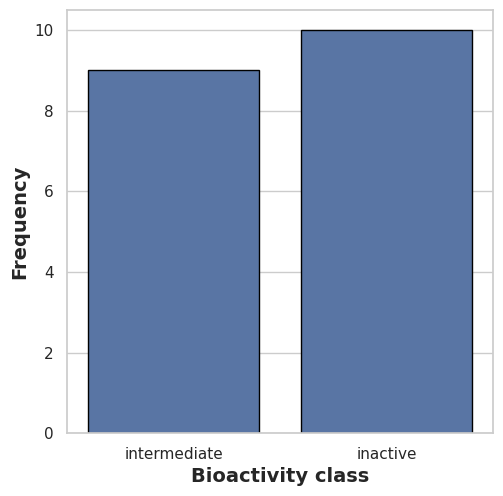

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

**Scatter plot of MW versus LogP**

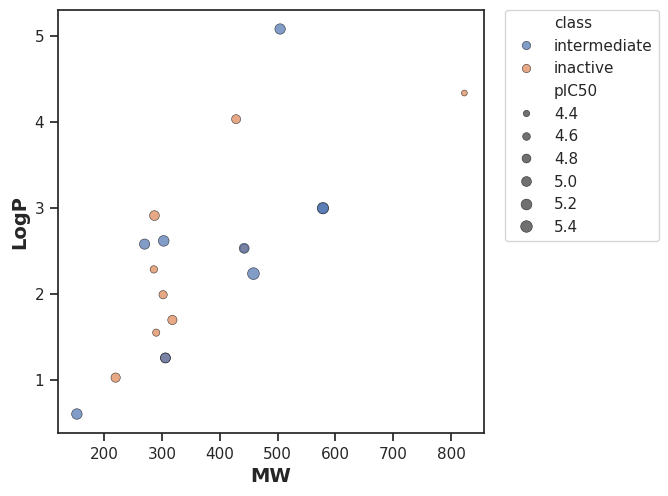

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

**Box plots**

pIC50 value

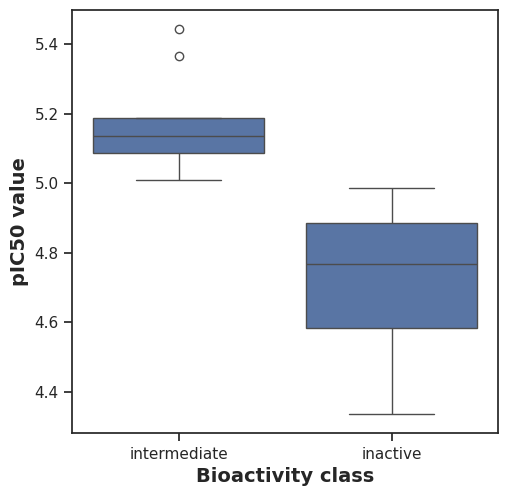

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='pIC50', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

**MW**

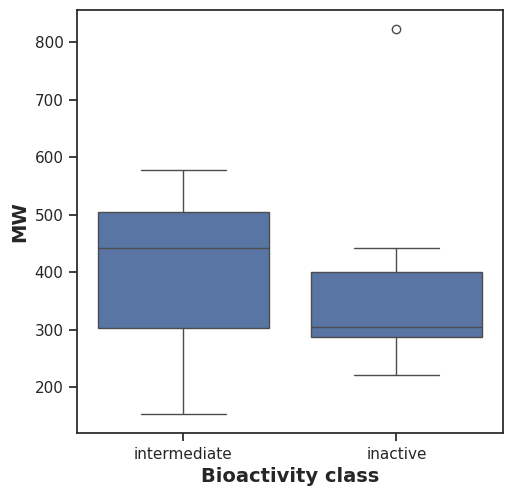

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x='class', y='MW', data=df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

**LogP**

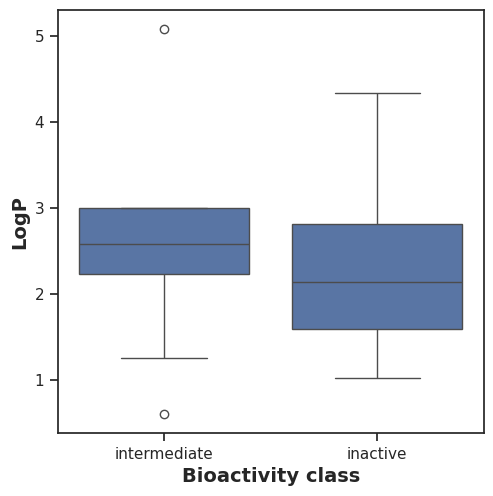

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

**NumHDonors**

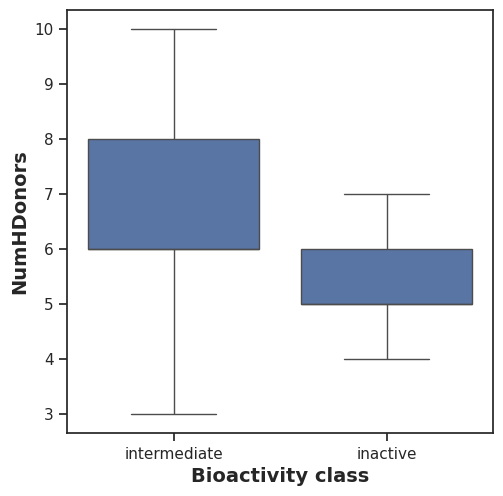

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

**NumHAcceptors**

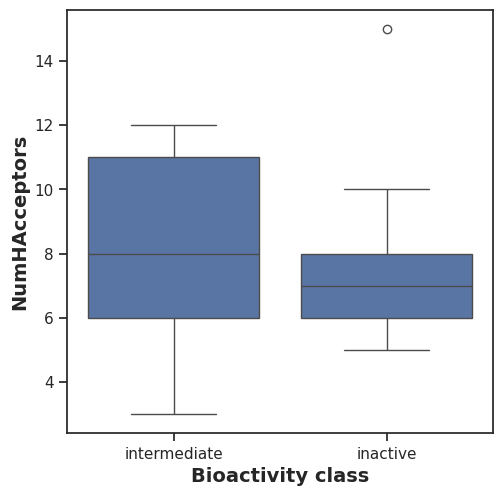

In [ ]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

### Compute the Padel discriptor v1

*   download padel.zip and padel.sh from github downloadable links
*   upzip the zip file
*   create a dataframe with canonical_smiles and molecule_id
*   save the file to csv without header or index as [ .smi ] file
*   run the .sh file using bash command

In [ ]:
# install PaDEL library
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip

--2024-11-15 08:06:23--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip [following]
--2024-11-15 08:06:23--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25768637 (25M) [application/zip]
Saving to: ‘padel.zip’

padel.zip           100%[===================>]  24.57M  --.-KB/s    in 0.08s   

2024-11-15 08:06:23 (301 MB/s) - ‘padel.zip’ saved [25768637/25768637]



In [ ]:
!wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

--2024-11-15 08:06:28--  https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh [following]
--2024-11-15 08:06:28--  https://raw.githubusercontent.com/dataprofessor/bioinformatics/master/padel.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 231 [text/plain]
Saving to: ‘padel.sh’

padel.sh            100%[===================>]     231  --.-KB/s    in 0s      

2024-11-15 08:06:28 (4.48 MB/s) - ‘padel.sh’ saved [231/231]



In [ ]:
!unzip padel.zip

Archive:  padel.zip
   creating: PaDEL-Descriptor/
  inflating: __MACOSX/._PaDEL-Descriptor  
  inflating: PaDEL-Descriptor/MACCSFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._MACCSFingerprinter.xml  
  inflating: PaDEL-Descriptor/AtomPairs2DFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._AtomPairs2DFingerprinter.xml  
  inflating: PaDEL-Descriptor/EStateFingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._EStateFingerprinter.xml  
  inflating: PaDEL-Descriptor/Fingerprinter.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._Fingerprinter.xml  
  inflating: PaDEL-Descriptor/.DS_Store  
  inflating: __MACOSX/PaDEL-Descriptor/._.DS_Store  
   creating: PaDEL-Descriptor/license/
  inflating: __MACOSX/PaDEL-Descriptor/._license  
  inflating: PaDEL-Descriptor/KlekotaRothFingerprintCount.xml  
  inflating: __MACOSX/PaDEL-Descriptor/._KlekotaRothFingerprintCount.xml  
  inflating: PaDEL-Descriptor/config  
  inflating: __MACOSX/PaDEL-Descriptor/._config  
  inf

In [ ]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
!cat molecule.smi | head -5
!cat molecule.smi | wc -l

O=c1cc(-c2ccccc2)oc2cc(O)c(O)c(O)c12	CHEMBL8260
O=C(O[C@@H]1Cc2c(O)cc(O)cc2O[C@H]1c1ccc(O)c(O)c1)c1cc(O)c(O)c(O)c1	CHEMBL129451
Oc1cc(O)c2cc(O)c(-c3ccc(O)c(O)c3)[o+]c2c1	CHEMBL511367
Oc1cc(O)c2cc(O)c(-c3cc(O)c(O)c(O)c3)[o+]c2c1	CHEMBL590878
NCCc1ccc(O)c(O)c1	CHEMBL59
19


In [ ]:
!cat padel.sh

java -Xms1G -Xmx1G -Djava.awt.headless=true -jar ./PaDEL-Descriptor/PaDEL-Descriptor.jar -removesalt -standardizenitro -fingerprints -descriptortypes ./PaDEL-Descriptor/PubchemFingerprinter.xml -dir ./ -file descriptors_output.csv


In [ ]:
# Compute PaDEL for the dataset
!bash padel.sh

Processing CHEMBL8260 in molecule.smi (1/19). 
Processing CHEMBL129451 in molecule.smi (2/19). 
Processing CHEMBL511367 in molecule.smi (3/19). Average speed: 2.70 s/mol.
Processing CHEMBL59 in molecule.smi (5/19). Average speed: 1.68 s/mol.
Processing CHEMBL590878 in molecule.smi (4/19). Average speed: 2.49 s/mol.
Processing CHEMBL583912 in molecule.smi (6/19). Average speed: 1.36 s/mol.
Processing CHEMBL36327 in molecule.smi (7/19). Average speed: 1.53 s/mol.
Processing CHEMBL47386 in molecule.smi (8/19). Average speed: 1.05 s/mol.
Processing CHEMBL125743 in molecule.smi (9/19). Average speed: 1.34 s/mol.
Processing CHEMBL264938 in molecule.smi (10/19). Average speed: 1.09 s/mol.
Processing CHEMBL286494 in molecule.smi (11/19). Average speed: 1.03 s/mol.
Processing CHEMBL4789704 in molecule.smi (12/19). Average speed: 1.06 s/mol.
Processing CHEMBL151 in molecule.smi (13/19). Average speed: 1.07 s/mol.
Processing CHEMBL164 in molecule.smi (14/19). Average speed: 1.02 s/mol.
Processing

In [ ]:
# Read the saved PaDEL descriptors in the file named "descriptors_output"
PaDEL = pd.read_csv('/content/descriptors_output.csv')
PaDEL = PaDEL.drop(columns=['Name'])

### Compute the Padel discriptor v2


In [ ]:
valid_descriptors = []
nonvalid_smiles = []

for smile in df['canonical_smiles'].tolist():
    try:
        descriptor = from_smiles(smile, descriptors=True, fingerprints=False)
        valid_descriptors.append(descriptor)
    except Exception as e:
        print(f"Error con el SMILES: {smile}. Detalle del error: {e}")
        nonvalid_smiles.append(smile)

Error con el SMILES: Cc1cc(O)c2c(=O)c3c(O)cc(O)c4c5c(O)cc(O)c6c(=O)c7c(O)cc(C)c8c1c2c(c34)c(c78)c65. Detalle del error: PaDEL-Descriptor encountered an error: PaDEL-Descriptor timed out during subprocess call


In [ ]:
# Create PaDEL DataFrame
PaDEL = pd.DataFrame(valid_descriptors)
PaDEL = PaDEL.apply(pd.to_numeric, errors='coerce')
PaDEL = pd.DataFrame(PaDEL)

In [ ]:
# Drop columns with NaN
PaDEL = PaDEL.dropna(axis='columns')

In [ ]:
# Drop columns with all zeros
PaDEL = PaDEL.loc[:, (PaDEL != 0).any(axis=0)]

In [ ]:
# Drop row with non generated descriptors
df2 = df.drop(df.loc[df['canonical_smiles'] == nonvalid_smiles[0]].index).reset_index()

In [ ]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [ ]:
# Scale data
PaDEL_scaled = robust_scaler.fit_transform(PaDEL)
PaDEL_scaled = minmax_scaler.fit_transform(PaDEL_scaled)

In [ ]:
# Create PaDEL scaled DataFrame
PaDEL = pd.DataFrame(PaDEL_scaled)
PaDEL.describe()

,0,1,2,3,4,5,6,7,8,9,...,1040,1041,1042,1043,1044,1045,1046,1047,1048,1049
count,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,...,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00,18.00
mean,0.56,0.33,0.13,0.27,0.46,0.46,0.24,0.34,0.18,0.32,...,0.64,0.35,0.65,0.38,0.57,0.09,0.17,0.36,0.31,0.38
std,0.27,0.28,0.23,0.24,0.28,0.23,0.24,0.24,0.23,0.24,...,0.26,0.24,0.22,0.24,0.28,0.25,0.24,0.24,0.27,0.24
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.43,0.15,0.03,0.14,0.33,0.25,0.11,0.21,0.04,0.20,...,0.58,0.22,0.64,0.22,0.40,0.00,0.05,0.23,0.11,0.24
50%,0.57,0.27,0.07,0.16,0.33,0.50,0.14,0.23,0.12,0.20,...,0.70,0.24,0.67,0.29,0.49,0.00,0.06,0.26,0.27,0.27
75%,0.72,0.41,0.15,0.34,0.67,0.50,0.29,0.44,0.20,0.40,...,0.76,0.46,0.71,0.51,0.79,0.00,0.20,0.45,0.47,0.49
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


### Compute the RDKit discriptor

In [36]:
def getMolDescriptors(smile, missingVal=None):
    ''' calculate the full list of descriptors for a molecule

        missingVal is used if the descriptor cannot be calculated
    '''
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(Chem.MolFromSmiles(smile))
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [37]:
# Calculate descriptors
descriptors = [getMolDescriptors(m) for m in df['canonical_smiles'].tolist()]

In [38]:
# Create RDKit DataFrame
RDKit = pd.DataFrame(descriptors)

In [39]:
# Drop columns with NaN
RDKit = RDKit.dropna(axis='columns')

In [40]:
# Initialization of data scalers
robust_scaler = RobustScaler()
minmax_scaler = MinMaxScaler()

In [41]:
# Scale data
RDKit_scaled = robust_scaler.fit_transform(RDKit)
RDKit_scaled = minmax_scaler.fit_transform(RDKit_scaled)

In [42]:
# Create RDKit scaled DataFrame
RDKit = pd.DataFrame(RDKit_scaled)
RDKit.describe()

,0,1,2,3,4,5,6,7,8,9,...,200,201,202,203,204,205,206,207,208,209
count,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,...,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00
mean,0.49,0.49,0.30,0.57,0.47,0.27,0.34,0.36,0.34,0.32,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
std,0.26,0.26,0.24,0.24,0.32,0.28,0.24,0.24,0.24,0.23,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.21,0.21,0.13,0.50,0.21,0.04,0.20,0.22,0.20,0.18,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.56,0.56,0.24,0.57,0.49,0.13,0.23,0.24,0.23,0.21,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,0.67,0.67,0.37,0.70,0.74,0.47,0.44,0.47,0.44,0.42,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


### Dimension Reduction Technique : VarianceThreshold


In [ ]:
selection = VarianceThreshold()
print("Before", PaDEL.shape)
PaDEL = selection.fit_transform(PaDEL)
print("After", PaDEL.shape)

Before (18, 1050)
After (18, 1050)


In [ ]:
selection = VarianceThreshold()
print("Before", RDKit.shape)
RDKit = selection.fit_transform(RDKit)
print("After", RDKit.shape)

Before (19, 210)
After (19, 141)


### Dimension Reduction Technique : PCA

Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

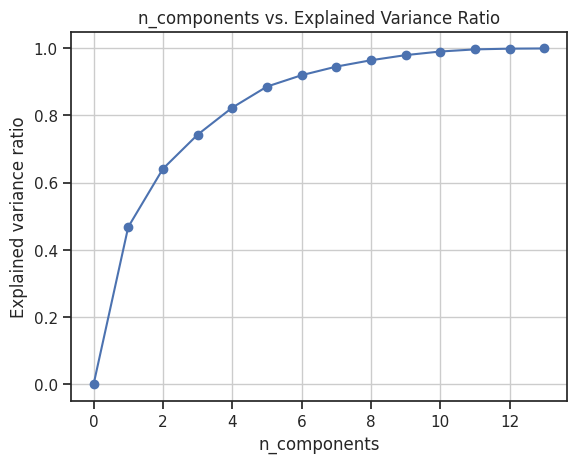

In [43]:
nums = np.arange(14)
var_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit(RDKit)
  var_ratio.append(np.sum(pca.explained_variance_ratio_))

plt.figure()
plt.plot(nums,var_ratio,marker='o')
plt.grid()
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [44]:
pca = PCA(n_components=11)
RDKit = pca.fit_transform(RDKit)

### Prepare the output/input dataframes

*   **Input:** PaDEL or RDKit descriptors
*   **Output:** pIC50 value

In [45]:
# input = PaDEL.copy()
# output = pd.DataFrame(df2["pIC50"], columns=["pIC50"])
input = RDKit.copy()
output = pd.DataFrame(df["pIC50"], columns=["pIC50"])

In [46]:
input_ = pd.DataFrame(input)
input_.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00,19.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00
std,2.19,1.33,1.02,0.91,0.80,0.59,0.51,0.44,0.39,0.33,0.25
min,-6.58,-3.64,-1.01,-1.13,-1.18,-1.01,-1.16,-0.85,-0.77,-0.65,-0.37
25%,-0.98,-0.29,-0.66,-0.70,-0.35,-0.67,-0.30,-0.34,-0.23,-0.21,-0.21
50%,0.52,0.11,-0.22,-0.23,-0.19,0.15,-0.18,0.09,0.02,-0.04,0.00
75%,1.45,0.80,0.28,0.75,0.23,0.49,0.53,0.28,0.27,0.13,0.19
max,2.84,2.00,3.09,1.57,2.65,0.78,0.73,0.80,0.83,0.80,0.39


In [ ]:
# Split the data to training and testing
X_train, X_test, Y_train, Y_test = train_test_split(input, output, test_size=0.30, random_state=3)

## Apply Machine Learning Algorithms

In [ ]:
# Defines and builds the lazyregressor
clf = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, Y_train, Y_test)

100%|██████████| 42/42 [00:03<00:00, 12.61it/s]

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 13, number of used features: 0
[LightGBM] [Info] Start training from score 4.944627
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spli

[(0.0, 1.0)]

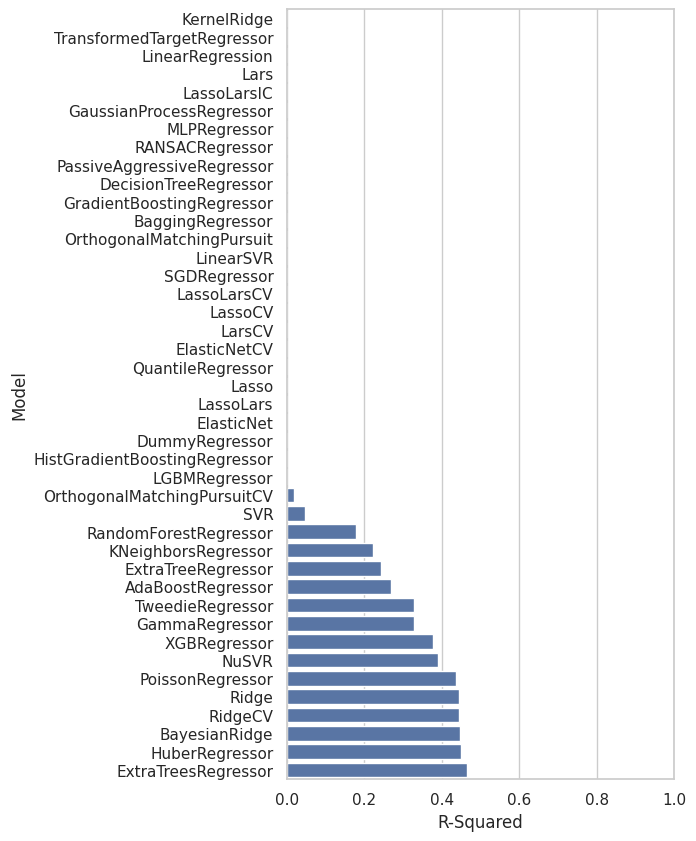

In [ ]:
# Bar plot of R-squared values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="R-Squared", data=predictions)
ax.set(xlim=(0, 1))

[(0.0, 10.0)]

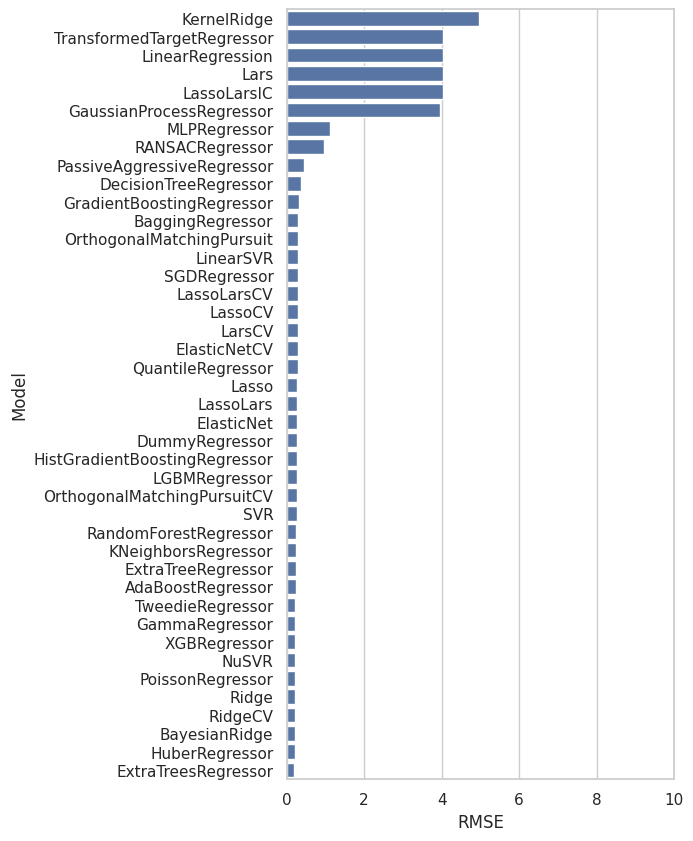

In [ ]:
# Bar plot of RMSE values
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="RMSE", data=predictions)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

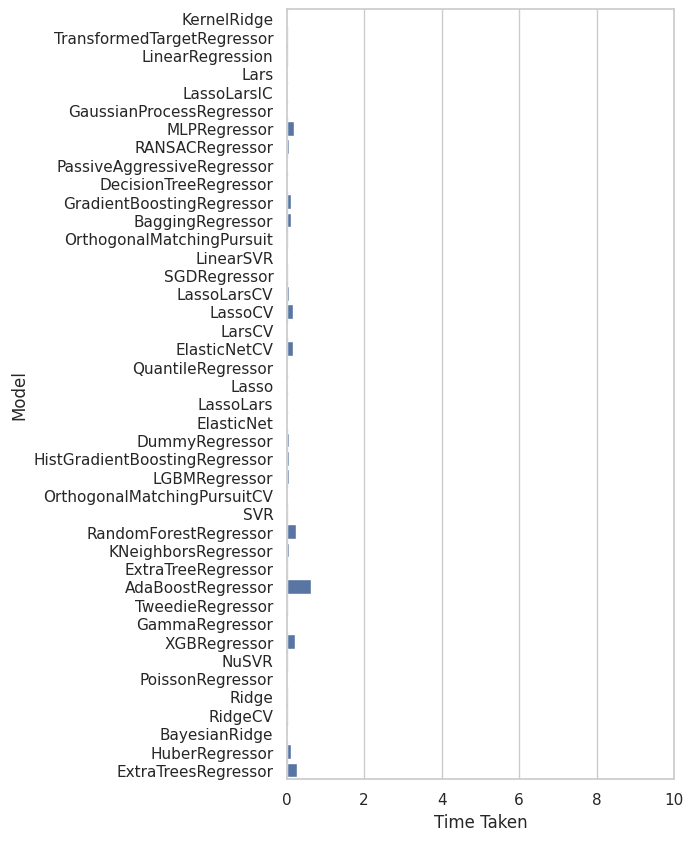

In [ ]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=predictions.index, x="Time Taken", data=predictions)
ax.set(xlim=(0, 10))

In [ ]:
print(models)

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
KernelRidge                                272.83    -325.19  4.96        0.04
TransformedTargetRegressor                 180.42    -214.30  4.03        0.02
LinearRegression                           180.42    -214.30  4.03        0.02
Lars                                       180.42    -214.30  4.03        0.03
LassoLarsIC                                180.42    -214.30  4.03        0.03
GaussianProcessRegressor                   173.81    -206.37  3.96        0.04
MLPRegressor                                14.92     -15.70  1.12        0.19
RANSACRegressor                             11.44     -11.53  0.97        0.07
PassiveAggressiveRegressor                   3.13      -1.56  0.44        0.02
DecisionTreeRegressor                        2.53      -0.83  0.37        0.04
GradientBoostingRegressor                    2.21   

In [47]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import (
    LinearRegression, Lars, LassoLarsIC, Lasso, ElasticNet, LassoCV, LarsCV,
    LassoLarsCV, ElasticNetCV, BayesianRidge, HuberRegressor, PassiveAggressiveRegressor,
    Ridge, RidgeCV, SGDRegressor, TweedieRegressor, GammaRegressor, PoissonRegressor
)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import OrthogonalMatchingPursuit, OrthogonalMatchingPursuitCV
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (
    GradientBoostingRegressor, BaggingRegressor, RandomForestRegressor,
    ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
)
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [48]:
# Regression models
models_ml = {
    "KernelRidge": KernelRidge(),
    "TransformedTargetRegressor": TransformedTargetRegressor(),
    "LinearRegression": LinearRegression(),
    "Lars": Lars(),
    "LassoLarsIC": LassoLarsIC(),
    "GaussianProcessRegressor": GaussianProcessRegressor(),
    "MLPRegressor": MLPRegressor(),
    "RANSACRegressor": RANSACRegressor(),
    "PassiveAggressiveRegressor": PassiveAggressiveRegressor(),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "BaggingRegressor": BaggingRegressor(),
    "OrthogonalMatchingPursuit": OrthogonalMatchingPursuit(),
    "LinearSVR": LinearSVR(),
    "SGDRegressor": SGDRegressor(),
    "LassoLarsCV": LassoLarsCV(),
    "LassoCV": LassoCV(),
    "LarsCV": LarsCV(),
    "ElasticNetCV": ElasticNetCV(),
    "Lasso": Lasso(),
    "LassoLars": Lasso(),
    "ElasticNet": ElasticNet(),
    "DummyRegressor": DummyRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(),
    "LGBMRegressor": LGBMRegressor(),
    "OrthogonalMatchingPursuitCV": OrthogonalMatchingPursuitCV(),
    "SVR": SVR(),
    "RandomForestRegressor": RandomForestRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "ExtraTreeRegressor": ExtraTreeRegressor(),
    "AdaBoostRegressor": AdaBoostRegressor(),
    "TweedieRegressor": TweedieRegressor(),
    "GammaRegressor": GammaRegressor(),
    "XGBRegressor": XGBRegressor(),
    "NuSVR": NuSVR(),
    "PoissonRegressor": PoissonRegressor(),
    "Ridge": Ridge(),
    "RidgeCV": RidgeCV(),
    "BayesianRidge": BayesianRidge(),
    "HuberRegressor": HuberRegressor(),
    "ExtraTreesRegressor": ExtraTreesRegressor()
}

In [51]:
print("{:>30} {:>30}".format(*["MODEL","SCORE"]))
for name, mdl in models_ml.items():
    kf = KFold(n_splits=4)
    score = cross_val_score(mdl,input,output,cv=kf,scoring='r2')
    show_values = [name,  np.round(np.mean(score),2)]
    print("{:>30} {:>30}".format(*show_values), np.round(score,2))

                         MODEL                          SCORE
                   KernelRidge                       -4741.87 [-4675.19 -1527.33 -6324.16 -6440.79]
    TransformedTargetRegressor                      -26189.94 [-1.394610e+03 -1.600000e-01 -9.483385e+04 -8.531130e+03]
              LinearRegression                      -26189.94 [-1.394610e+03 -1.600000e-01 -9.483385e+04 -8.531130e+03]
                          Lars              -3655394219636.85 [-1.46206940e+13 -1.60000000e-01 -1.04012090e+05 -8.82814818e+08]
                   LassoLarsIC                          -0.52 [-3.44  0.05  0.67  0.66]
      GaussianProcessRegressor                        -228.93 [-481.49 -139.05 -231.28  -63.92]
                  MLPRegressor                         -84.79 [-132.27 -125.52  -80.56   -0.83]
               RANSACRegressor                       -57438.9 [-1.3946100e+03 -1.6000000e-01 -2.2788121e+05 -4.7961000e+02]
    PassiveAggressiveRegressor                         -84.27 [ -5

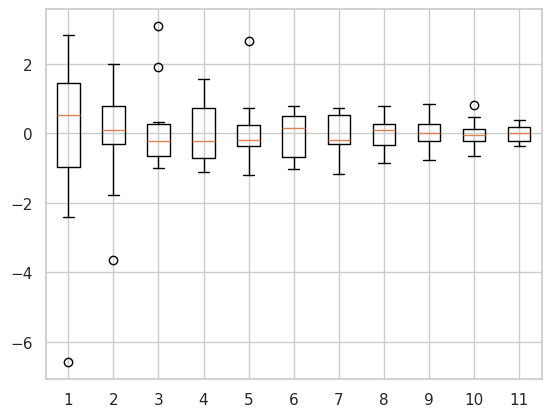

In [ ]:
plt.boxplot(input)
plt.show()

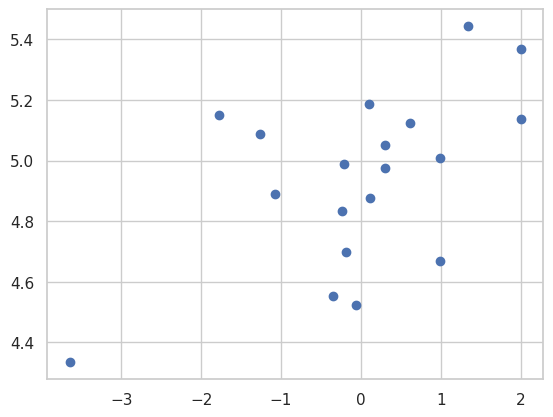

In [ ]:
plt.scatter(input[:,1],output)
plt.show()